# Trail Camera Image Classifier

This notebook originated directly from the Fast.ai Deep Learning course v3 [Lesson 1](https://github.com/fastai/course-v3/raw/master/nbs/dl1/lesson1-pets.ipynb)

It has been modified to see if it is possible to use the same approach to classify images from trail cameras.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

## Cuda Support

The next 4 lines check to see if there is CUDA support available.

In [3]:
import torch
index = torch.cuda.current_device()
print(torch.cuda.device(index))
print(torch.cuda.get_device_name(index))
torch.cuda.is_available()

Quadro P1000


True

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [4]:
# bs = 64
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We have changed from the dog breeds image set from the original Fast.ai lesson and instead are using a selection of images taken directly from a set of trail cameras provided by DeerDat.com

In [5]:
path = pathlib.Path('C:/Users/JLangley/.fastai/data/deerdat')

In [6]:
path.ls()

[WindowsPath('C:/Users/JLangley/.fastai/data/deerdat/buck'),
 WindowsPath('C:/Users/JLangley/.fastai/data/deerdat/doe'),
 WindowsPath('C:/Users/JLangley/.fastai/data/deerdat/empty'),
 WindowsPath('C:/Users/JLangley/.fastai/data/deerdat/models'),
 WindowsPath('C:/Users/JLangley/.fastai/data/deerdat/person'),
 WindowsPath('C:/Users/JLangley/.fastai/data/deerdat/racoon')]

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_folder` gets the labels from the directories that the images are in.

In our case, we have copied images of each category (~25-30 per category) into a folder with the same name as the category we want to classify.

In [7]:
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, size=224, bs=bs
                                  ).normalize(imagenet_stats)

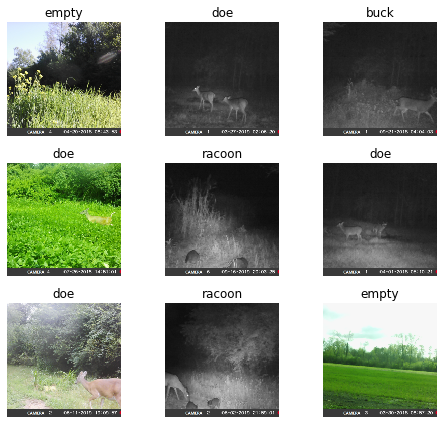

In [8]:
data.show_batch(rows=3, figsize=(7,6))

You can see that in this example we have daytime and night vision images of deer (does & bucks), racoons, people, and some that have nothing but a background.

We can tell that there may be an issue with having multiple categories of animals in the same image, but we'll go with it for now to see what happens.

In [9]:
print(data.classes)
len(data.classes),data.c

['buck', 'doe', 'empty', 'person', 'racoon']


(5, 5)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [11]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.557700,1.088776,0.360000,00:58
1,1.590866,0.524802,0.200000,00:55
2,1.137490,0.180604,0.080000,00:55
3,0.854171,0.150149,0.080000,00:55


In [13]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

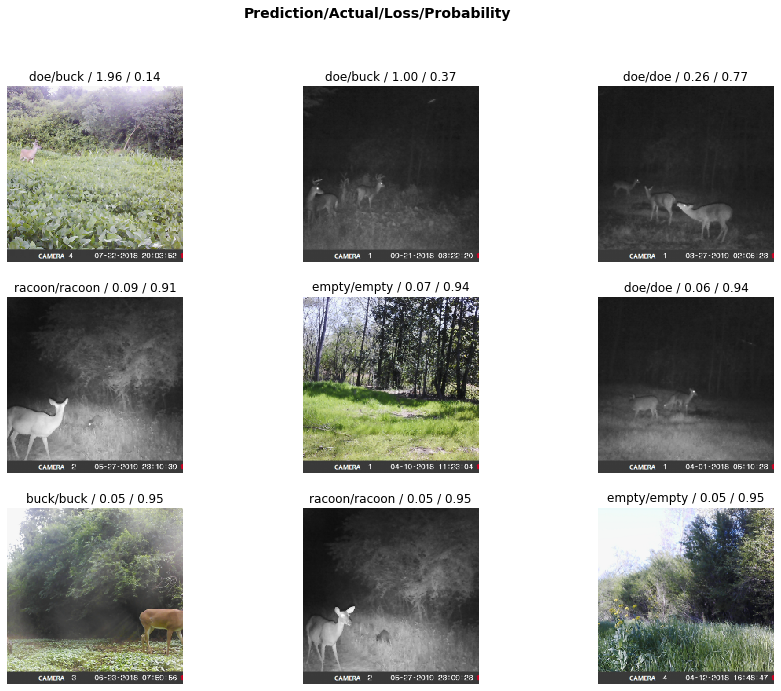

In [15]:
interp.plot_top_losses(9, figsize=(15,11))

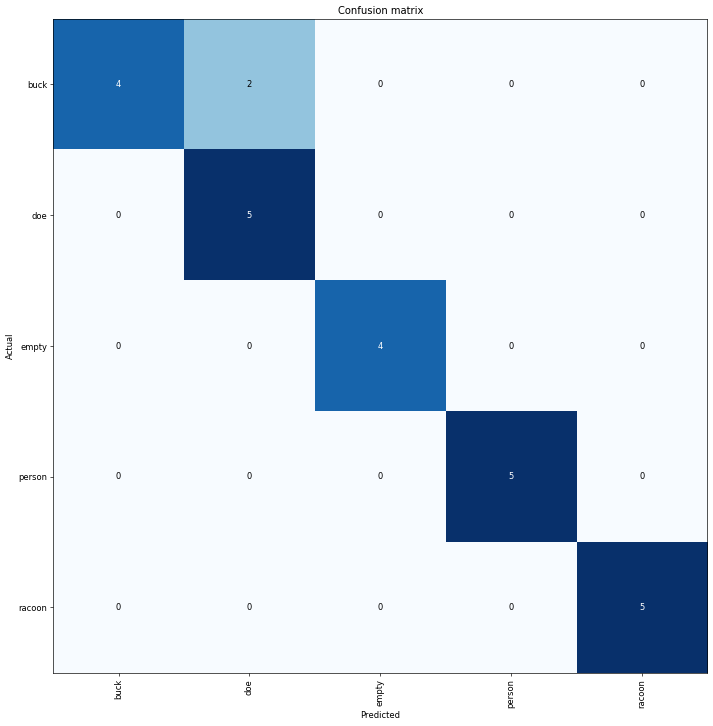

In [16]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [17]:
interp.most_confused(min_val=2)

[('buck', 'doe', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [18]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.847428,0.553338,0.160000,00:57


In [20]:
learn.load('stage-1');

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


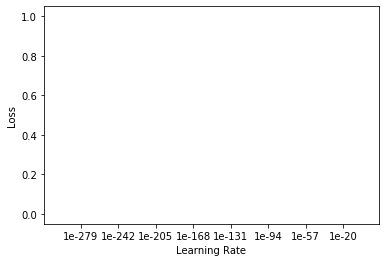

In [24]:
learn.recorder.plot()

In [23]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.346265,0.393373,0.120000,00:58
1,0.394982,0.137451,0.080000,00:58


That's a pretty accurate model!